# Contrastive Loss

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import make_blobs
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Функция потерь Contrastive Loss
def contrastive_loss(x1, x2, y, margin=1.0):
    dist = F.pairwise_distance(x1, x2)
    loss = (1 - y) * dist.pow(2) + y * F.relu(margin - dist).pow(2)
    return loss.mean()

# Генерация случайных векторов для проверки
x1 = torch.randn(100, 2).to(device)
x2 = torch.randn(100, 2).to(device)
y_same = torch.zeros(100).to(device)
y_diff = torch.ones(100).to(device)

# Проверка на случайных векторах
loss_same = contrastive_loss(x1, x1, y_same)
loss_diff = contrastive_loss(x1, x2, y_diff)

print(f"Loss (same): {loss_same.item():.4f}")
print(f"Loss (diff): {loss_diff.item():.4f}")

# Генерация кластеров
X, y = make_blobs(n_samples=500, centers=3, n_features=2, random_state=0)
X_tensor = torch.tensor(X, dtype=torch.float).to(device)
y_tensor = torch.tensor(y).to(device)

# Генерация пар

def generate_pairs(X, y, num_samples=1000):
    same_class_pairs = []
    diff_class_pairs = []
    for _ in range(num_samples):
        i, j = random.sample(range(len(X)), 2)
        if y[i] == y[j]:
            same_class_pairs.append((i, j))
        else:
            diff_class_pairs.append((i, j))
    return same_class_pairs, diff_class_pairs

same_pairs, diff_pairs = generate_pairs(X_tensor, y_tensor)

# Расчет средней потери по парам

def compute_average_loss(pairs, X, label, margin=1.0):
    losses = []
    for i, j in pairs:
        x1 = X[i].unsqueeze(0)
        x2 = X[j].unsqueeze(0)
        y_label = torch.tensor([label], dtype=torch.float).to(device)
        losses.append(contrastive_loss(x1, x2, y_label, margin).item())
    return np.mean(losses)
  
def collect_losses(pairs, X, label, margin=1.0):
    losses = []
    for i, j in pairs:
        x1 = X[i].unsqueeze(0)
        x2 = X[j].unsqueeze(0)
        y_label = torch.tensor([label], dtype=torch.float).to(device)
        loss = contrastive_loss(x1, x2, y_label, margin).item()
        losses.append(loss)
    return losses

Loss (same): 0.0000
Loss (diff): 0.0359


In [17]:
# Сравнение значений
same_loss = compute_average_loss(same_pairs, X_tensor, label=0)
diff_loss = compute_average_loss(diff_pairs, X_tensor, label=1)

print(f"Average loss (same class): {same_loss:.4f}")
print(f"Average loss (different class): {diff_loss:.4f}")

Average loss (same class): 4.2439
Average loss (different class): 0.0008


Количество пар внутри одного кластера: 331
Количество пар между кластерами: 669


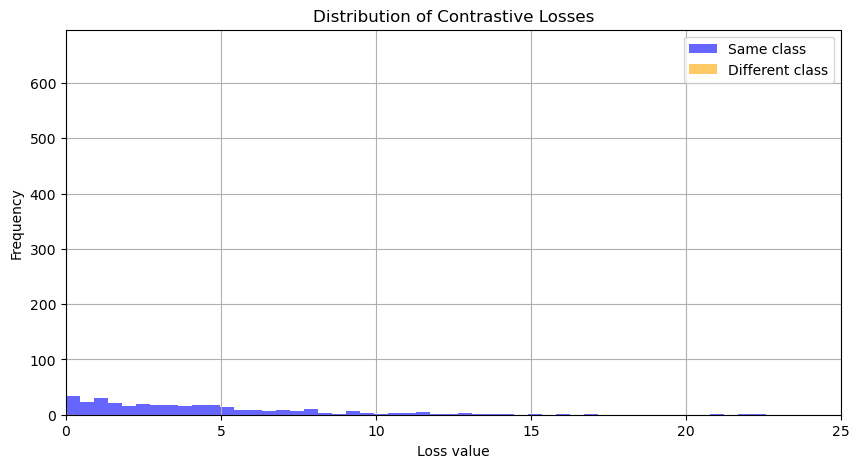

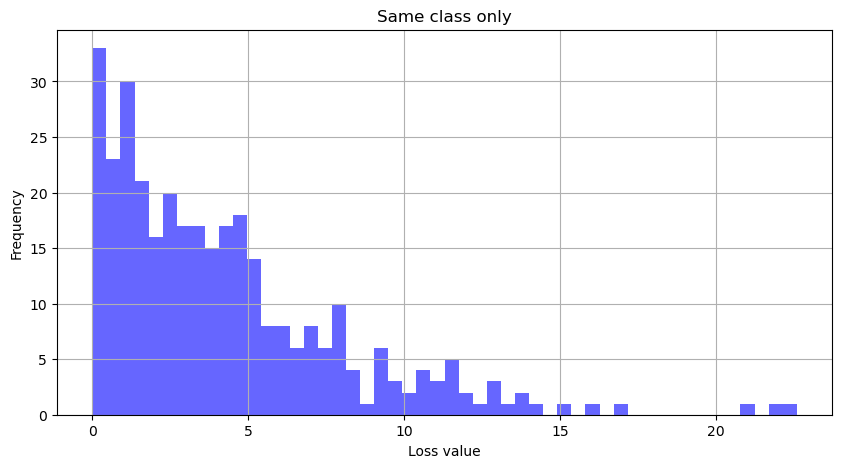

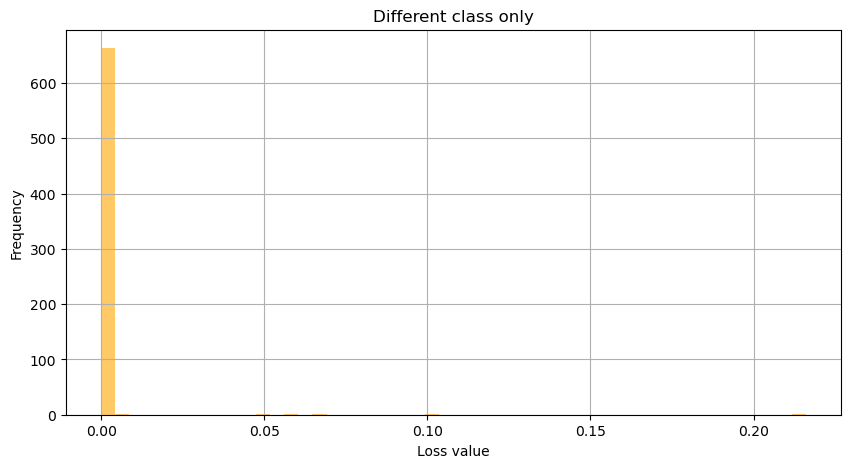

In [20]:
import matplotlib.pyplot as plt

# Визуализация распределения потерь
same_losses = collect_losses(same_pairs, X_tensor, label=0)
diff_losses = collect_losses(diff_pairs, X_tensor, label=1)

print(f"Количество пар внутри одного кластера: {len(same_losses)}")
print(f"Количество пар между кластерами: {len(diff_losses)}")

# Основная гистограмма
plt.figure(figsize=(10, 5))
plt.hist(same_losses, bins=50, alpha=0.6, label='Same class', color='blue')
plt.hist(diff_losses, bins=50, alpha=0.6, label='Different class', color='orange')
plt.xlabel('Loss value')
plt.ylabel('Frequency')
plt.title('Distribution of Contrastive Losses')
plt.legend()
plt.grid(True)
plt.xlim(0, 25)
plt.show()

# Отдельные гистограммы для каждого класса
plt.figure(figsize=(10, 5))
plt.hist(same_losses, bins=50, alpha=0.6, color='blue')
plt.xlabel('Loss value')
plt.ylabel('Frequency')
plt.title('Same class only')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(diff_losses, bins=50, alpha=0.6, color='orange')
plt.xlabel('Loss value')
plt.ylabel('Frequency')
plt.title('Different class only')
plt.grid(True)
plt.show()